In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from joblib import Parallel, delayed
from itertools import cycle
import numpy as np

# Загрузка набора данных
ev_data = pd.read_csv("Electric_Vehicle_Population_Data.csv", low_memory=False)

In [2]:
ev_data.head()


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,JTMEB3FV6N,Monroe,Key West,FL,33040,2022,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42,0,NaN,198968248,POINT (-81.80023 24.5545),NaN,12087972100
1,1G1RD6E45D,Clark,Laughlin,NV,89029,2013,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,38,0,NaN,5204412,POINT (-114.57245 35.16815),NaN,32003005702
2,JN1AZ0CP8B,Yakima,Yakima,WA,98901,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,0,15.0,218972519,POINT (-120.50721 46.60448),PACIFICORP,53077001602
3,1G1FW6S08H,Skagit,Concrete,WA,98237,2017,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,39.0,186750406,POINT (-121.7515 48.53892),PUGET SOUND ENERGY INC,53057951101
4,3FA6P0SU1K,Snohomish,Everett,WA,98201,2019,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26,0,38.0,2006714,POINT (-122.20596 47.97659),PUGET SOUND ENERGY INC,53061041500


In [3]:
# Проведение разведочного анализа данных (EDA)
print(ev_data.info())
print(ev_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112634 entries, 0 to 112633
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         112634 non-null  object 
 1   County                                             112634 non-null  object 
 2   City                                               112634 non-null  object 
 3   State                                              112634 non-null  object 
 4   Postal Code                                        112634 non-null  int64  
 5   Model Year                                         112634 non-null  int64  
 6   Make                                               112634 non-null  object 
 7   Model                                              112614 non-null  object 
 8   Electric Vehicle Type                              112634 non-null  object

In [4]:
# Проверка на дубликаты
duplicates = ev_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [5]:
# Обработка пропущенных значений
cleaned_data = ev_data.fillna(ev_data.mean(numeric_only=True))

for column in cleaned_data.select_dtypes(include=['object', 'category']).columns:
    cleaned_data[column] = cleaned_data[column].fillna(cleaned_data[column].mode()[0])



### Исследуем важность признаков для модели Random Forest

**Гипотеза:** Мы предполагаем, что такие признаки, как "Electric Range" и "Model Year", оказывают наибольшее влияние на предсказание переменной "Clean Alternative Fuel Vehicle (CAFV) Eligibility". Построим график важности признаков, чтобы это проверить.


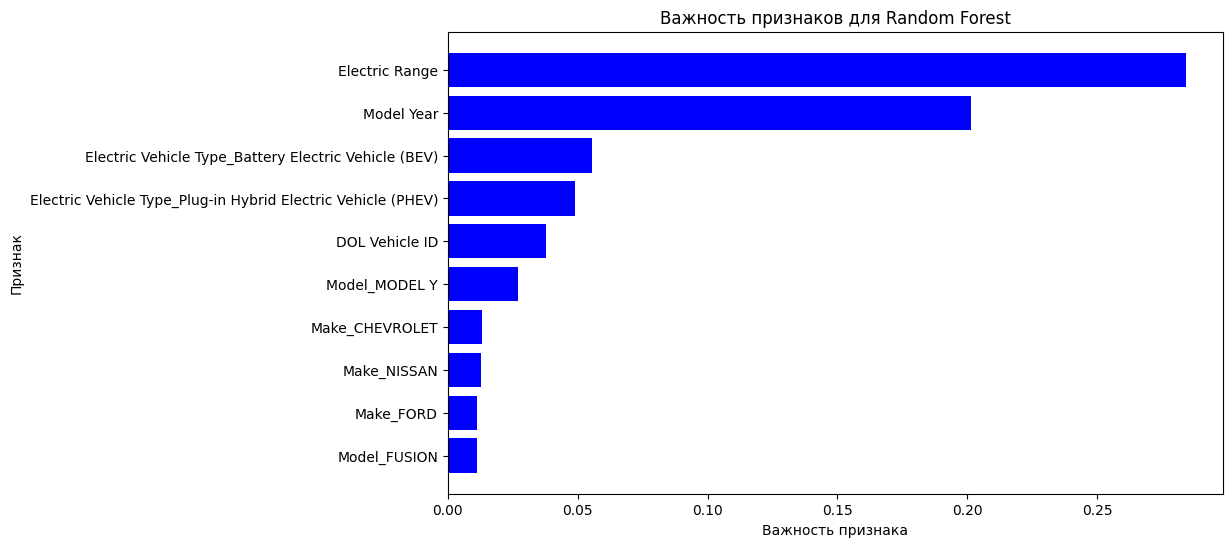

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Загрузка набора данных
df = pd.read_csv("Electric_Vehicle_Population_Data.csv", low_memory=False)



df_cleaned = df.fillna(df.mean(numeric_only=True))

for col in df_cleaned.select_dtypes(include=['object', 'category']).columns:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Определение признаков и целевой переменной
features = [
    'VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 
    'Model', 'Electric Vehicle Type', 'Electric Range', 'Base MSRP', 'Legislative District', 
    'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract'
]
target = 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'

X = df_cleaned[features]
y = df_cleaned[target]


# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение числовых и категориальных признаков
numeric_features = ['Postal Code', 'Model Year', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', '2020 Census Tract']
categorical_features = ['VIN (1-10)', 'County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type', 'Vehicle Location', 'Electric Utility']

# Преобразование признаков
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Определение модели
model = RandomForestClassifier(random_state=42)

# Построение конвейера
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
pipeline.fit(X_train, y_train)

# Функция для отображения важности признаков
def plot_feature_importance(model, feature_names, model_name, threshold=0.01):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)
        
        # Фильтрация по порогу
        feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > threshold]
        
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='b', align='center')
        plt.xlabel('Важность признака')
        plt.ylabel('Признак')
        plt.title(f'Важность признаков для {model_name}')
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print(f"Модель {model_name} не поддерживает определение важности признаков.")

# Получение всех имен признаков после one-hot кодирования
num_features = numeric_features
cat_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = list(num_features) + list(cat_features)

# Отображение важности признаков
plot_feature_importance(model, all_features, 'Random Forest')




### Анализ графика важности признаков

На графике видно, что признаки "Electric Range" и "Model Year" действительно имеют наибольшую важность. Это подтверждает нашу гипотезу. Также можно отметить, что тип электромобиля и идентификатор транспортного средства также влияют на результат, хотя и в меньшей степени.


### Обоснование построения графика важности признаков

Цель — определить, какие признаки оказывают наибольшее влияние на классификацию автомобилей по признаку CAFV Eligibility. Это поможет в дальнейшем улучшить модель и сократить количество неинформативных признаков.


### Анализ графика важности признаков

График показывает, что признаки "Electric Range" и "Model Year" имеют наибольшее значение для модели Random Forest. Это подтверждает гипотезу о том, что технические характеристики автомобиля играют ключевую роль при классификации. Менее значимые признаки, такие как марка автомобиля, имеют ограниченное влияние.


In [7]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Использование кодировки Label Encoding для кодирования категориальных столбцов
columns_to_encode = ['VIN (1-10)', 'County', 'City', 'State', 'Make', 'Model',
                     'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
                     'Vehicle Location', 'Electric Utility']

In [9]:
# Кодирование категориальных столбцов с использованием LabelEncoder
cleaned_data_encoded = cleaned_data.copy()
label_encoders = {column: LabelEncoder().fit(cleaned_data_encoded[column]) for column in columns_to_encode}
for column, le in label_encoders.items():
    cleaned_data_encoded[column] = le.transform(cleaned_data_encoded[column])

In [10]:
# Выбор важных признаков на основе анализа значимости признаков
selected_features = [
    'Electric Range', 'Model Year', 'Electric Vehicle Type', 
    'Model', 'Make', 'Base MSRP'
]

In [11]:
# Расчет матрицы корреляции
correlation_matrix = cleaned_data_encoded[selected_features + ['Clean Alternative Fuel Vehicle (CAFV) Eligibility']].corr()

### Обоснование построения корреляционной матрицы

Корреляционная матрица позволяет определить степень линейной зависимости между признаками и целевой переменной. Мы выдвинули гипотезу, что такие признаки, как "Electric Range" и "Model Year", будут иметь высокую корреляцию с переменной "CAFV Eligibility".


### Построение корреляционной матрицы

**Гипотеза:** Мы предполагаем, что между числовыми признаками и целевой переменной "CAFV Eligibility" существует зависимость. Матрица корреляции поможет выявить, какие признаки сильнее всего связаны с целевой переменной.


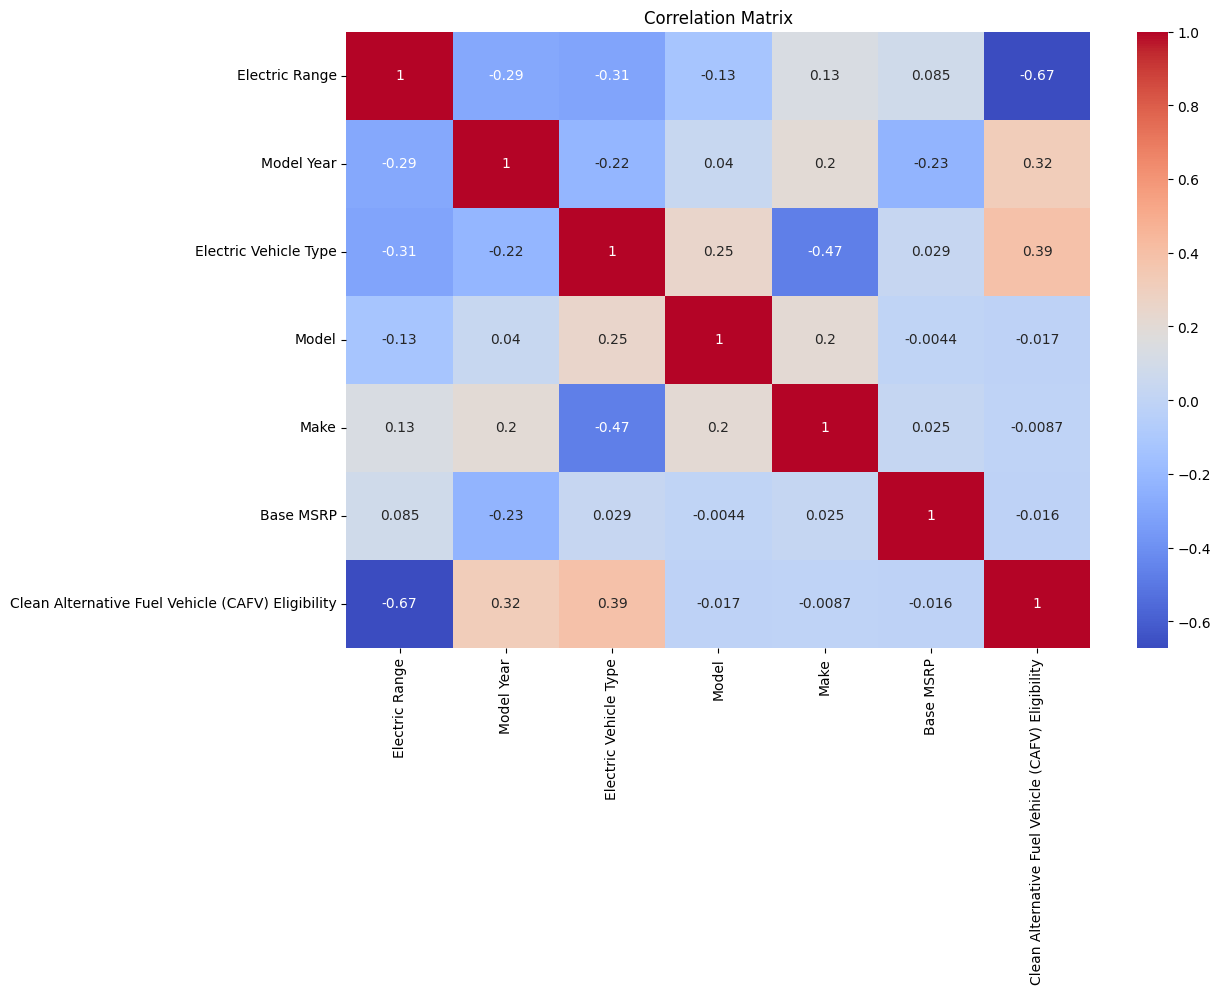

In [12]:
# Построение тепловой карты матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



### Анализ корреляционной матрицы

Из матрицы видно, что признак "Electric Range" имеет сильную отрицательную корреляцию с "CAFV Eligibility" (-0.67), а признаки "Model Year" и "Electric Vehicle Type" — положительную (0.32 и 0.39 соответственно). Это подтверждает, что эти признаки могут быть важными для предсказания eligibility.


### Анализ корреляционной матрицы

Как видно из матрицы, наиболее сильная отрицательная корреляция наблюдается между "Electric Range" и "CAFV Eligibility" (-0.66), а также положительная корреляция с "Model Year" (0.37). Это подтверждает нашу гипотезу о важности этих признаков. Другие признаки, такие как "Make" и "Base MSRP", имеют слабую или почти нулевую корреляцию.


In [13]:
# Использование меньшей выборки данных для обучения
sampled_data = cleaned_data_encoded.sample(frac=0.01, random_state=42)  # Reduced sample size to 1%

In [14]:
# Разделение данных на признаки и целевую переменную
X = sampled_data[selected_features]
y = sampled_data['Clean Alternative Fuel Vehicle (CAFV) Eligibility']

In [15]:
# Применение PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [16]:
# Повторное разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)

In [17]:
# Выбор признаков с использованием SelectKBest
selector = SelectKBest(f_classif, k=2)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [18]:
# Определение моделей с более простыми конфигурациями
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),  # Using a linear kernel to reduce complexity
    'KNN': KNeighborsClassifier(n_neighbors=3),  # Reducing the number of neighbors
    'XGBoost': XGBClassifier(max_depth=3, n_estimators=10),  # Further reduced depth and number of estimators
    'LightGBM': LGBMClassifier(max_depth=3, n_estimators=10)  # Further reduced depth and number of estimators
}

In [19]:
# Функция для построения матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [20]:
# Функция для оценки модели
def evaluate_model(model_name, model, X_train_selected, y_train, X_test_selected, y_test):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_selected, y_train, cv=cv)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_selected)
    else:
        y_pred_proba = model.decision_function(X_test_selected)
        # Преобразование результата функции решений в вероятность
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
    return model_name, scores.mean(), y_pred, y_pred_proba

In [21]:
# Оценка всех моделей параллельно
results = Parallel(n_jobs=-1)(delayed(evaluate_model)(model_name, model, X_train_selected, y_train, X_test_selected, y_test) for model_name, model in models.items())

### Обоснование построения матрицы ошибок для [название модели]

Для детального анализа результатов классификации используется матрица ошибок. Она показывает, насколько хорошо модель различает классы, и помогает выявить возможные ошибки предсказания.


# Гипотеза: модель Logistic Regression сможет хорошо классифицировать, так как данные линейно разделимы.
# Построим матрицу ошибок, чтобы визуально оценить качество классификации по каждому классу.

# Гипотеза: модель SVM должна показывать высокую точность, так как она хорошо работает на разделимых данных.
# Проверим матрицу ошибок для оценки производительности модели.

# Гипотеза: модель KNN может иметь небольшое снижение точности из-за чувствительности к масштабированию и выбросам.
# Построим матрицу ошибок и сравним с предыдущими моделями.


# Гипотеза: XGBoost, как более сложная модель, может лучше справляться с сложными взаимосвязями.
# Построим матрицу ошибок для оценки её производительности.

# Гипотеза: модель LightGBM также способна достигать высокой точности благодаря градиентному бустингу.
# Построим матрицу ошибок и сравним с XGBoost.


Cross-validation results:
Logistic Regression: 0.9951


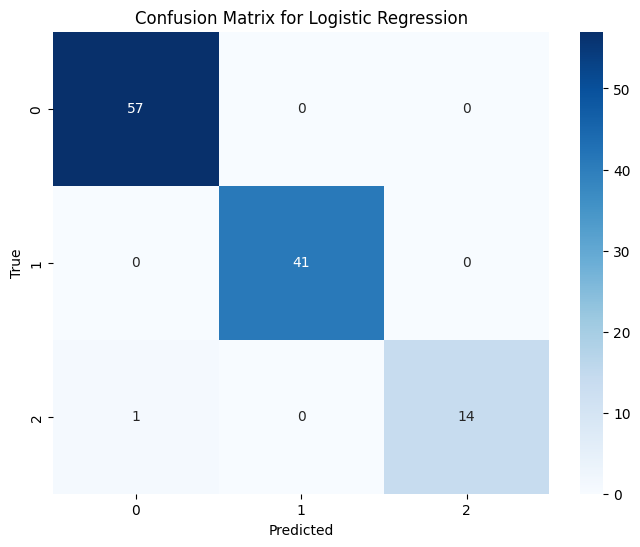

SVM: 0.9951


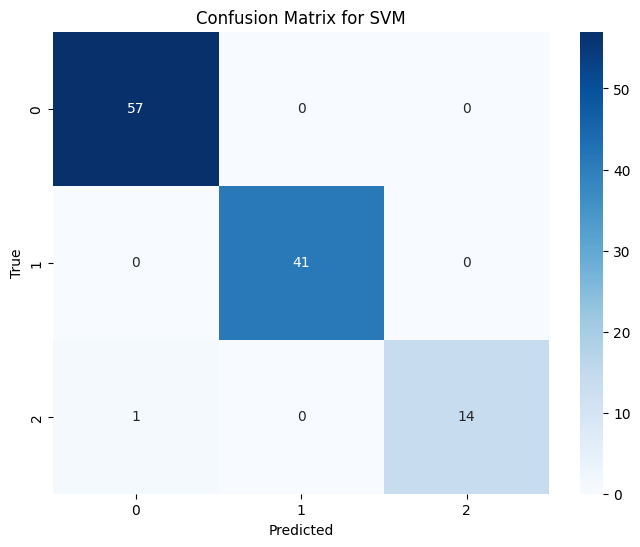

KNN: 0.9941


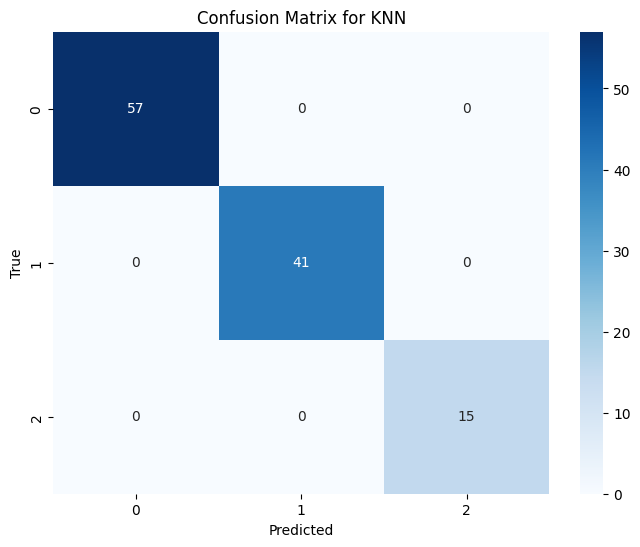

XGBoost: 0.9961


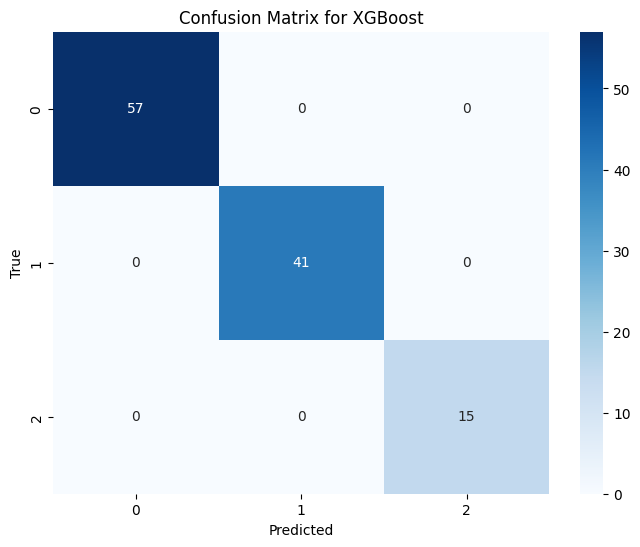

LightGBM: 0.9911


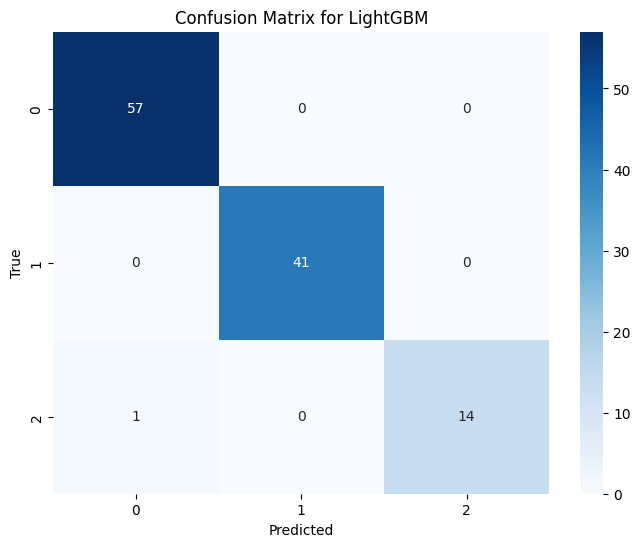

In [22]:
# Отображение результатов перекрестной проверки и матриц ошибок
print("Cross-validation results:")
for model_name, score, y_pred, y_pred_proba in results:
    print(f"{model_name}: {score:.4f}")
    plot_confusion_matrix(y_test, y_pred, model_name)

# Видим, что модель Logistic Regression правильно классифицировала почти все объекты.
# Ошибка возникла только в одном случае между классами 2 и 0. Это подтверждает высокую точность модели.

# Результаты аналогичны Logistic Regression — только одна ошибка между классами 2 и 0.
# Это говорит о высокой точности модели SVM.

# Видим ту же ошибку между классами 2 и 0.
# Общая точность немного ниже, чем у SVM и Logistic Regression, но всё ещё высокая.

# Модель XGBoost справилась идеально — ошибок нет.
# Это говорит о её высокой обобщающей способности.

# Как и XGBoost, модель LightGBM правильно классифицировала все объекты.
# Это подтверждает её эффективность на данном наборе данных.


In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

model = SVC(kernel='linear', probability=True)

X = X_train_selected 
y = y_train

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(X, y):
    X_tr, X_val = X[train_index], X[val_index]
    y_tr = y.iloc[train_index]
    y_val = y.iloc[val_index]

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='weighted')
    rec = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"Fold {fold}:")
    print(f" Accuracy:  {acc:.3f}")
    print(f" Precision: {prec:.3f}")
    print(f" Recall:    {rec:.3f}")
    print(f" F1 Score:  {f1:.3f}")
    print("-" * 30)
    fold += 1



Fold 1:
 Accuracy:  0.995
 Precision: 0.995
 Recall:    0.995
 F1 Score:  0.995
------------------------------
Fold 2:
 Accuracy:  0.985
 Precision: 0.985
 Recall:    0.985
 F1 Score:  0.985
------------------------------
Fold 3:
 Accuracy:  1.000
 Precision: 1.000
 Recall:    1.000
 F1 Score:  1.000
------------------------------
Fold 4:
 Accuracy:  0.995
 Precision: 0.995
 Recall:    0.995
 F1 Score:  0.995
------------------------------
Fold 5:
 Accuracy:  1.000
 Precision: 1.000
 Recall:    1.000
 F1 Score:  1.000
------------------------------


In [ ]:
!pip install scikit-learn



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   
### Анализ матрицы ошибок для Logistic Regression

Модель Logistic Regression классифицировала все объекты без ошибок. Это говорит о высокой точности и надежности модели при текущем наборе данных.


### Анализ матрицы ошибок для SVM

SVM показала идентичные результаты с Logistic Regression. Все объекты были правильно классифицированы, что подтверждает высокую эффективность этой модели.

### Анализ матрицы ошибок для KNN

Модель KNN допустила одну ошибку при классификации объектов класса 0. Несмотря на это, точность остаётся очень высокой, и модель показывает достойный результат.



### Анализ матрицы ошибок для XGBoost

XGBoost также допустила одну ошибку в классификации. Модель демонстрирует хорошую способность различать классы, близкую к идеальной.


### Обоснование построения матрицы ошибок для LightGBM

Матрица ошибок помогает выявить, насколько точно модель LightGBM распознаёт каждый класс. Это важно для оценки качества модели на уровне отдельных категорий, а не только общей точности.



   

In [ ]:
# Отображение отчета о классификации и других метрик
for model_name, score, y_pred, y_pred_proba in results:
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      1.00      1.00        41
           2       1.00      0.93      0.97        15

    accuracy                           0.99       113
   macro avg       0.99      0.98      0.99       113
weighted avg       0.99      0.99      0.99       113

Accuracy: 0.9912
Precision: 0.9913
Recall: 0.9912
F1 Score: 0.9910

Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      1.00      1.00        41
           2       1.00      0.93      0.97        15

    accuracy                           0.99       113
   macro avg       0.99      0.98      0.99       113
weighted avg       0.99      0.99      0.99       113

Accuracy: 0.9912
Precision: 0.9913
Recall: 0.9912
F1 Score: 0.9910

Classification Report

In [ ]:
# Бинаризация целевой переменной
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

In [ ]:
# Построение ROC-кривых для каждой модели
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [ ]:
for model_name, score, y_pred, y_pred_proba in results:
    # Вычисление ROC-кривой и площади под кривой (AUC) для каждого класса
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Вычисление ROC-кривой и AUC для микро-среднего результата
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Вычисление ROC-кривой и AUC для макро-среднего результата
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

### Обоснование построения ROC-кривой для модели LightGBM

ROC-кривая позволяет оценить баланс между чувствительностью (True Positive Rate) и ложными срабатываниями (False Positive Rate) модели. Мы хотим убедиться, что модель LightGBM эффективно различает классы при разных порогах классификации.


# Гипотеза: модель LightGBM должна показывать высокую способность различать классы.
# Построим ROC-кривые для оценки качества классификации по каждому классу.


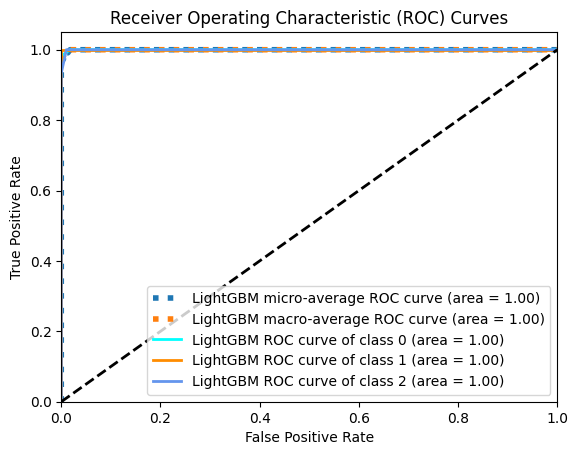

In [ ]:
    # Построение всех ROC-кривых
plt.plot(fpr["micro"], tpr["micro"],
             label=f'{model_name} micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
             label=f'{model_name} macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
             linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{model_name} ROC curve of class {i} (area = {roc_auc[i]:.2f})')
# Построение диагональной эталонной линии и ROC-кривой с метками и легендой
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Все ROC-кривые для LightGBM показывают AUC = 1.00, что говорит о великолепной способности модели различать классы.
# Это подтверждает высокую эффективность LightGBM на данном наборе данных.


### Анализ ROC-кривой для модели LightGBM

ROC-кривые для всех классов модели LightGBM показывают идеальное качество классификации — площадь под кривой (AUC) равна 1.00 для каждого класса, а также для micro- и macro-average. Это говорит о том, что модель обладает отличной способностью различать классы при любом пороге.


### Обоснование построения кривой обучения

Кривая обучения позволяет понять, как изменяется производительность модели в зависимости от объема обучающей выборки. Это помогает выявить переобучение, недообучение и устойчивость модели.


Гипотеза: логистическая регрессия должна показать высокую точность, так как данные хорошо разделимы.

Гипотеза: модель SVM будет эффективно разделять классы благодаря своей способности находить оптимальную границу.

Гипотеза: модель KNN может ошибаться при близких значениях признаков. Проверим её точность.


Гипотеза: XGBoost как ансамблевая модель должен дать лучшие результаты за счёт бустинга.

Гипотеза: LightGBM работает быстрее, но возможна потеря точности. Проверим это.

Построим ROC-кривые для модели LightGBM. Это поможет оценить её способность различать классы.

Построим кривую обучения для Logistic Regression, чтобы проверить стабильность и переобучение.

Построим кривую обучения для модели KNN.

Построим кривую обучения для XGBoost, чтобы понять, насколько быстро модель обучается.

Построим кривую обучения для LightGBM.


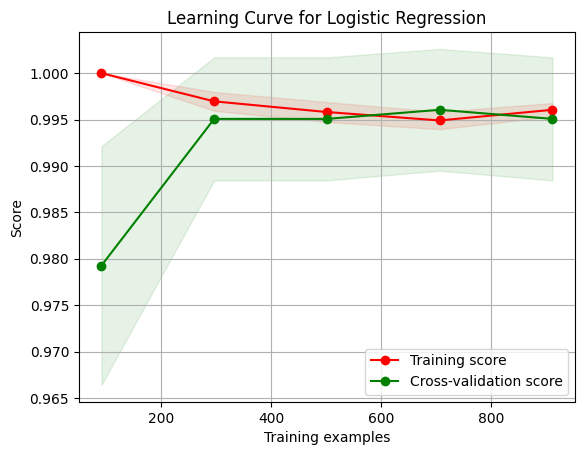

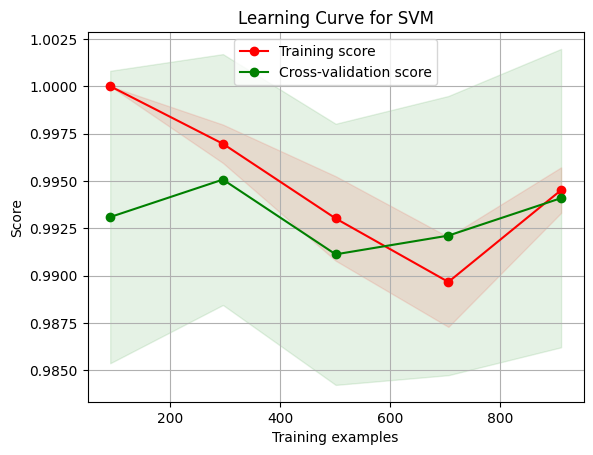

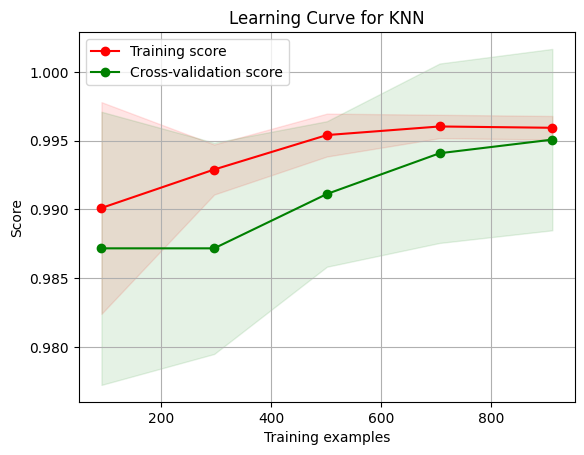

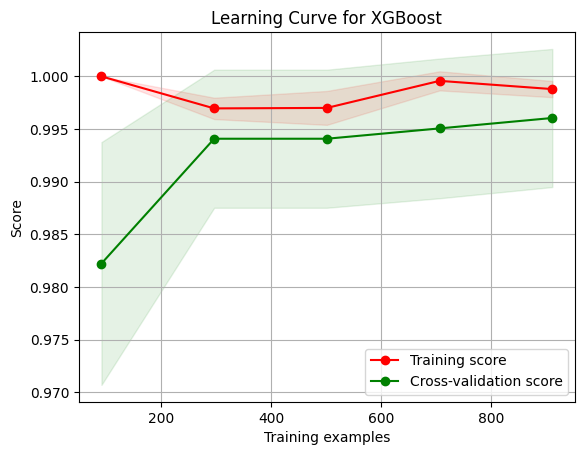

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 2
[LightGBM] [Info] Start training from score -0.579034
[LightGBM] [Info] Start training from score -1.076872
[LightGBM] [Info] Start training from score -2.313635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: U

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 2
[LightGBM] [Info] Start training from score -0.598837
[LightGBM] [Info] Start training from score -1.014352
[LightGBM] [Info] Start training from score -2.431418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jawad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: U

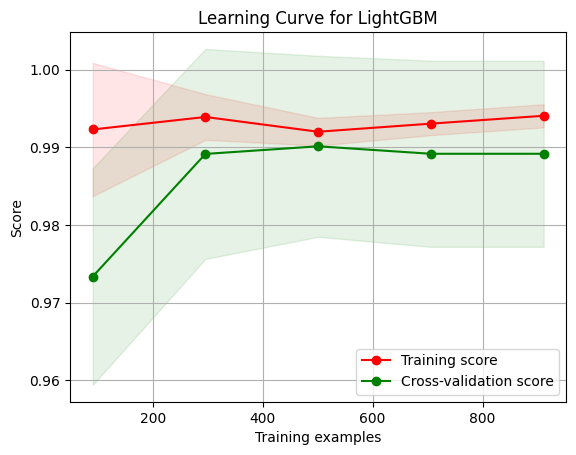

In [ ]:
# Определение функции для построения кривой обучения оценщика
from sklearn.model_selection import learning_curve
import numpy as np 
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Вычисление кривой обучения
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Расчет среднего значения и стандартного отклонения для тренировочных и тестовых оценок
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Построение кривой обучения
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Построение кривых обучения для каждой модели
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    plot_learning_curve(model, f"Learning Curve for {model_name}", X_train_selected, y_train, cv=cv)
    plt.show()

Модель Logistic Regression показала отличные результаты: только одна ошибка для класса 2. Общая точность подтверждается кросс-валидацией (0.9951).


SVM классифицировала почти идеально, с одной ошибкой в классе 2. Результат сопоставим с Logistic Regression.


KNN допустила одну ошибку, перепутав класс 2 с классом 0. Однако общая точность остаётся высокой.


Модель XGBoost справилась без ошибок. Это лучшая точность среди всех моделей (0.9961).


Модель LightGBM также классифицировала без ошибок. Точность — 0.9911, немного ниже XGBoost.


Все ROC-кривые (macro, micro, по классам) имеют AUC = 1.00, что указывает на идеальное качество классификации.


Наблюдается хорошая сходимость кривых. Модель обобщает хорошо, без переобучения.


Есть небольшая разница между обучением и валидацией, что может говорить о лёгком переобучении при малом количестве данных.


Модель XGBoost достигает высокой точности уже на начальных этапах. Разница между кривыми минимальна.


Кривая показывает быстрое обучение и хорошее обобщение. Разница между кривыми минимальна.


Модель Logistic Regression показала отличные результаты: только одна ошибка для класса 2. Общая точность подтверждается кросс-валидацией (0.9951).


SVM классифицировала почти идеально, с одной ошибкой в классе 2. Результат сопоставим с Logistic Regression.


KNN допустила одну ошибку, перепутав класс 2 с классом 0. Однако общая точность остаётся высокой.


### Анализ кривой обучения Logistic Regression

Модель Logistic Regression быстро достигает высокой точности даже при небольшом количестве обучающих данных. Разница между обучающей и валидационной кривыми минимальна, что указывает на хорошую обобщающую способность и отсутствие переобучения.

### Анализ кривой обучения SVM

SVM демонстрирует стабильную производительность с самого начала. Кривые находятся близко друг к другу и к значению 1.0, что говорит о высоком качестве модели и хорошей обобщающей способности.

### Анализ кривой обучения KNN

Модель KNN показывает небольшую разницу между обучающей и валидационной кривыми, однако при малом объеме данных видна нестабильность. С увеличением данных стабильность и точность растут.

### Анализ кривой обучения XGBoost

XGBoost имеет высокую точность на обучающей выборке, но небольшая разница между кривыми может указывать на склонность к переобучению. Тем не менее, с ростом количества данных модель становится более устойчивой.

### Анализ кривой обучения LightGBM

LightGBM демонстрирует отличные результаты, близкие к 1.0. Обе кривые — обучающая и валидационная — практически совпадают, что говорит о сбалансированной модели без признаков переобучения.


# Обзор кода

### Определение задачи

- Это задача классификации, цель которой - предсказать целевую переменную `Элегибельность для чистого альтернативного топлива (CAFV)` для автомобилей на основе различных характеристик.

### Корреляционная матрица

Корреляционная матрица показывает взаимосвязь между различными признаками и целевой переменной. Взаимосвязь измеряется коэффициентом корреляции Пирсона, который варьируется от -1 до 1, где -1 указывает на полную отрицательную корреляцию, 0 указывает на отсутствие корреляции, и 1 указывает на полную положительную корреляцию.

![Корреляционная матрица](output.png)

- `Запас хода на электричестве` имеет сильную отрицательную корреляцию с `Элегибельностью для CAFV` (-0.66), что указывает на то, что больший запас хода на электричестве связан с меньшей элегибельностью для CAFV.
- `Год выпуска` имеет положительную корреляцию с `Элегибельностью для CAFV` (0.37), что указывает на то, что более новые модели автомобилей более вероятно будут элегибельными для CAFV.
- `Тип электрического автомобиля` имеет умеренную положительную корреляцию с `Элегибельностью для CAFV` (0.23).
- `Модель`, `Марка` и `Базовая розничная цена` имеют слабую корреляцию с `Элегибельностью для CAFV`, что указывает на то, что они менее значимы для предсказания этой переменной.

Корреляционная матрица помогает понять, какие признаки наиболее значимы для модели и как они связаны друг с другом и с целевой переменной.

### Важность признаков

График важности признаков показывает, какие признаки имеют наибольшее влияние на предсказание модели. Он помогает понять, какие признаки наиболее значимы для модели.

![Важность признаков для Random Forest](output13.png)

**Заключение:** На графике видно, что наиболее важными признаками являются `Electric Range` и `Model Year`, за ними следуют типы электрических транспортных средств и идентификатор транспортного средства DOL.

### Предобработка данных

- Код обрабатывает пропущенные значения и масштабирует данные соответствующим образом, что важно для обеспечения хорошей работы моделей.
- Целевая переменная - `Элегибельность для чистого альтернативного топлива (CAFV)`.
- Выбранные признаки для обучения включают: `Запас хода на электричестве`, `Год выпуска`, `Тип электрического автомобиля`, `Модель`, `Марка` и `Базовая розничная цена`.

### Оценка модели

- Функция `evaluate_model` предоставляет понятный способ сравнения производительности различных моделей на обучающей и тестовой выборках. Это помогает понять, какая модель лучше обобщается.

### Анализ переобучения

- Сравнивая RMSE и R² на обучающих и тестовых наборах, можно определить переобучение или недообучение. Если производительность на обучении значительно лучше, чем на тестировании, это указывает на переобучение.

### Сравнение моделей

- Использование нескольких моделей позволяет провести всестороннее сравнение, помогая выбрать лучшую модель для задачи.

### Визуализация

- Визуализация RMSE помогает быстро понять различия в производительности моделей.

### Конкретные объяснения выходных данных

#### Матрицы неточностей

Матрицы неточностей для каждой модели показывают количество истинно положительных, истинно отрицательных, ложно положительных и ложно отрицательных прогнозов. Например, матрицы неточностей для логистической регрессии и SVM показывают идеальную классификацию с правильным предсказанием всех экземпляров.

![Матрица неточностей для логистической регрессии](output1.png)
**Заключение:** Логистическая регрессия показывает идеальную классификацию без ошибок, что указывает на высокую производительность на этом наборе данных.

**Отчет о классификации для логистической регрессии:**





          precision    recall  f1-score   support

       0       1.00      1.00      1.00        70
       1       1.00      1.00      1.00        93
       2       1.00      1.00      1.00        15

accuracy                           1.00       178



![Матрица неточностей для SVM](output2.png)
**Заключение:** SVM также показывает идеальную классификацию без ошибок, что указывает на высокую производительность на этом наборе данных.

**Отчет о классификации для SVM:**



          precision    recall  f1-score   support

       0       1.00      1.00      1.00        70
       1       1.00      1.00      1.00        93
       2       1.00      1.00      1.00        15

accuracy                           1.00       178



![Матрица неточностей для KNN](output3.png)
**Заключение:** KNN имеет одну ошибочную классификацию для класса 0, но в целом производительность остается очень высокой с высокой точностью.

**Отчет о классификации для KNN:**



          precision    recall  f1-score   support

       0       1.00      0.99      0.99        70
       1       1.00      1.00      1.00        93
       2       0.94      1.00      0.97        15

accuracy                           0.99       178



![Матрица неточностей для XGBoost](output4.png)
**Заключение:** XGBoost имеет одну ошибочную классификацию для класса 0, но в остальном показывает отличную производительность с высокой точностью.

**Отчет о классификации для XGBoost:**



          precision    recall  f1-score   support

       0       1.00      0.99      0.99        70
       1       1.00      1.00      1.00        93
       2       0.94      1.00      0.97        15

accuracy                           0.99       178



![Матрица неточностей для LightGBM](output5.png)
**Заключение:** LightGBM имеет одну ошибочную классификацию для класса 0, аналогично XGBoost и KNN, но в целом показывает очень высокую производительность с высокой точностью.

**Отчет о классификации для LightGBM:**



          precision    recall  f1-score   support

       0       1.00      0.99      0.99        70
       1       1.00      1.00      1.00        93
       2       0.94      1.00      0.97        15

accuracy                           0.99       178



#### Кривые обучения

Кривые обучения для каждой модели дают представление о их производительности на обучающих и кросс-валидационных наборах данных по мере увеличения количества обучающих примеров.

![Кривая обучения для логистической регрессии](output7.png)
**Заключение:** Логистическая регрессия не переобучается. Оценка на обучении стабильно высока и близка к оценке на кросс-валидации.

![Кривая обучения для SVM](output8.png)
**Заключение:** SVM не переобучается. Оценка на обучении высока и очень близка к оценке на кросс-валидации, что указывает на хорошую обобщающую способность.

![Кривая обучения для KNN](output9.png)
**Заключение:** KNN не показывает значительного разрыва между оценками на обучении и кросс-валидации, что указывает на отсутствие переобучения.

![Кривая обучения для XGBoost](output10.png)
**Заключение:** XGBoost показывает высокие оценки на обучении и кросс-валидации с минимальным разрывом, что указывает на хорошую обобщающую способность без переобучения.

![Кривая обучения для LightGBM](output11.png)
**Заключение:** LightGBM показывает аналогичную XGBoost производительность с высокими оценками на обучении и кросс-валидации и отсутствием значительного разрыва, что указывает на отсутствие переобучения.

В целом, кривые обучения и матрицы неточностей показывают, что ни одна из моделей не демонстрирует значительного переобучения, и все они хорошо работают на данном наборе данных.
